In [49]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

import IPython.display as ipd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.utils import shuffle

import librosa
import librosa.display
import ast

import keras
plt.rcParams['figure.figsize'] = (17, 5)



In [50]:
df = pd.read_csv('data.csv')

In [51]:
df.head()

,filename,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,...,-27.326481,-20.607473,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512
1,54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,...,-5.424025,6.843907,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876
2,65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,...,-8.586940,6.649025,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801
3,71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,...,5.303405,-0.030636,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687
4,57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,...,-8.056653,-5.495337,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378


In [52]:
df.shape

(7997, 30)

In [53]:
genres = pd.read_csv('data/fma_metadata/genrelist.csv')

In [54]:
genres

,Unnamed: 0,genre,testtrainval
0,NaN,NaN,NaN
1,track_id,NaN,NaN
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
...,...,...,...
7997,154308,Hip-Hop,test
7998,154309,Hip-Hop,test
7999,154413,Pop,training
8000,154414,Pop,training


In [7]:
genres.rename({'Unnamed: 0':'track_id'},axis=1,inplace=True)

In [8]:
genres = genres.drop(index=[0,1])

In [9]:
genres.head()

,track_id,genre,testtrainval
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
5,140,Folk,training
6,141,Folk,training


In [10]:
genres['track_id'] = genres['track_id'].astype('int64')

In [11]:
df.rename({'filename':'track_id'},axis=1,inplace=True)

In [12]:
df['track_id']

0       126014
1        54496
2        65893
3        71158
4        57821
         ...  
7992     43695
7993     68410
7994     51291
7995     96902
7996     75441
Name: track_id, Length: 7997, dtype: int64

In [13]:
data=pd.merge(df,genres,on='track_id')

In [14]:
data['genre']

0        Instrumental
1        Experimental
2                Folk
3             Hip-Hop
4             Hip-Hop
            ...      
7992    International
7993     Experimental
7994              Pop
7995     Experimental
7996     Instrumental
Name: genre, Length: 7997, dtype: object

In [15]:
data.set_index('track_id',inplace=True)

In [16]:
data.head()

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre,testtrainval
track_id,,,,,,,,,,,,,,,,,,,,,
126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,-352.161438,...,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512,Instrumental,training
54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,-290.169464,...,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876,Experimental,training
65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,-80.027184,...,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801,Folk,training
71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,-123.564980,...,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687,Hip-Hop,training
57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,-71.340874,...,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378,Hip-Hop,training


In [17]:
y = data[['genre']]

In [18]:
X = data.drop(['genre','testtrainval'],axis=1)

In [19]:
X_train, X_test, y_train , y_test = train_test_split(X,y,stratify=y,test_size=0.2)

In [20]:
X_train.shape, X_test.shape

((6397, 29), (1600, 29))

In [21]:
X_train, X_val, y_train , y_val = train_test_split(X,y,stratify=y,test_size=1500)

In [22]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Transform the product labels to numerical values
lb = LabelBinarizer()
lb.fit(y_train)

y_train_lb = to_categorical(lb.transform(y_train))[:, :, 1]
y_val_lb = to_categorical(lb.transform(y_val))[:, :, 1]
y_test_lb = to_categorical(lb.transform(y_test))[:, :, 1]

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [25]:
random.seed(123)
from keras import models
from keras import layers
baseline_model = models.Sequential()
baseline_model.add(layers.Dense(50, activation='relu', input_shape=(29,)))
baseline_model.add(layers.Dense(25, activation='relu'))
baseline_model.add(layers.Dense(8, activation='softmax'))

In [26]:
# Compile the model
baseline_model.compile(optimizer='Adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

In [27]:
# Train the model
baseline_model_val = baseline_model.fit(X_train, 
                                        y_train_lb, 
                                        epochs=150, 
                                        batch_size=256, 
                                        validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 0s 27us/step - loss: 2.0277 - acc: 0.2255 - val_loss: 1.9177 - val_acc: 0.3080
Epoch 2/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.8647 - acc: 0.3140 - val_loss: 1.8028 - val_acc: 0.3367
Epoch 3/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.7669 - acc: 0.3548 - val_loss: 1.7291 - val_acc: 0.3633
Epoch 4/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6977 - acc: 0.3819 - val_loss: 1.6793 - val_acc: 0.3807
Epoch 5/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6477 - acc: 0.4020 - val_loss: 1.6454 - val_acc: 0.3893
Epoch 6/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6119 - acc: 0.4125 - val_loss: 1.6228 - val_acc: 0.3980
Epoch 7/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.5888 - acc: 0.4264 - val_loss: 1.6058 - val_acc: 0.4040
Epoch 

Epoch 61/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.2880 - acc: 0.5452 - val_loss: 1.4603 - val_acc: 0.4833
Epoch 62/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.2862 - acc: 0.5435 - val_loss: 1.4646 - val_acc: 0.4800
Epoch 63/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.2831 - acc: 0.5461 - val_loss: 1.4629 - val_acc: 0.4760
Epoch 64/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.2808 - acc: 0.5490 - val_loss: 1.4623 - val_acc: 0.4813
Epoch 65/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.2790 - acc: 0.5490 - val_loss: 1.4663 - val_acc: 0.4807
Epoch 66/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.2766 - acc: 0.5475 - val_loss: 1.4653 - val_acc: 0.4820
Epoch 67/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.2735 - acc: 0.5475 - val_loss: 1.4645 - val_acc: 0.4773
Epoch 68/150
6497/6497 [========================

6497/6497 [==============================] - 0s 7us/step - loss: 1.1739 - acc: 0.5875 - val_loss: 1.4958 - val_acc: 0.4727
Epoch 122/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.1737 - acc: 0.5901 - val_loss: 1.5034 - val_acc: 0.4753
Epoch 123/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.1732 - acc: 0.5898 - val_loss: 1.5002 - val_acc: 0.4693
Epoch 124/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.1721 - acc: 0.5897 - val_loss: 1.4995 - val_acc: 0.4807
Epoch 125/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.1712 - acc: 0.5883 - val_loss: 1.5082 - val_acc: 0.4740
Epoch 126/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.1674 - acc: 0.5937 - val_loss: 1.5062 - val_acc: 0.4747
Epoch 127/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.1651 - acc: 0.5935 - val_loss: 1.5053 - val_acc: 0.4720
Epoch 128/150
6497/6497 [==============================

In [28]:
# Access the history attribute and store the dictionary
baseline_model_val_dict = baseline_model_val.history

# Print the keys
baseline_model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [29]:
results_train = baseline_model.evaluate(X_train, y_train_lb)
print('----------')
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

6497/6497 [==============================] - 0s 15us/step
----------
Training Loss: 1.13 
Training Accuracy: 0.607


In [30]:
results_test = baseline_model.evaluate(X_test, y_test_lb)
print('----------')
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

1600/1600 [==============================] - 0s 17us/step
----------
Test Loss: 1.2 
Test Accuracy: 0.594


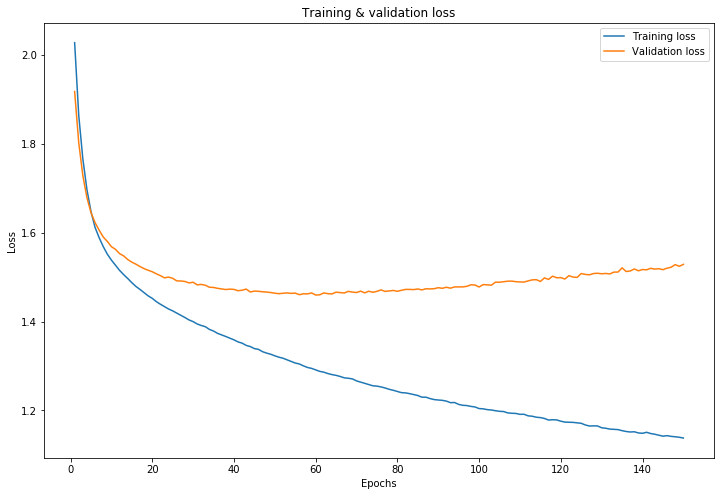

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))

loss_values = baseline_model_val_dict['loss']
val_loss_values = baseline_model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
ax.plot(epochs, loss_values, label='Training loss')
ax.plot(epochs, val_loss_values, label='Validation loss')

ax.set_title('Training & validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

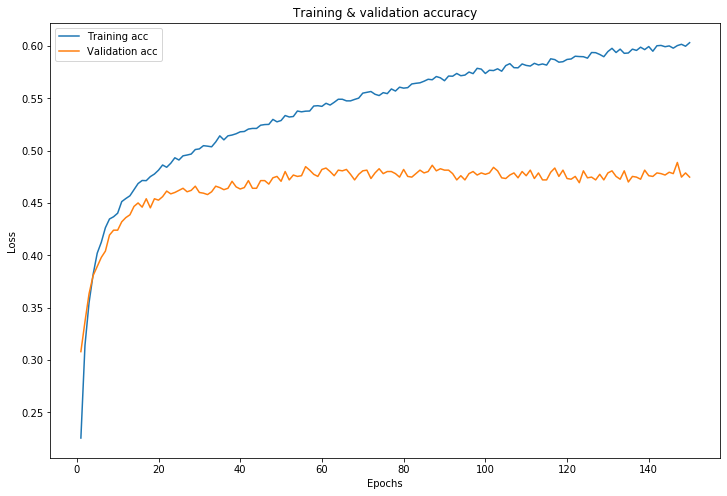

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))

acc_values = baseline_model_val_dict['acc'] 
val_acc_values = baseline_model_val_dict['val_acc']

ax.plot(epochs, acc_values, label='Training acc')
ax.plot(epochs, val_acc_values, label='Validation acc')
ax.set_title('Training & validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [33]:
random.seed(123)
model_2 = models.Sequential()
model_2.add(layers.Dense(50, activation='relu', input_shape=(29,)))
model_2.add(layers.Dense(25, activation='relu'))
model_2.add(layers.Dense(8, activation='softmax'))

model_2.compile(optimizer='SGD', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [35]:
model_2_val = model_2.fit(X_train, 
                          y_train_lb, 
                          epochs=150, 
                          callbacks=early_stopping, 
                          batch_size=256, 
                          validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 0s 23us/step - loss: 2.1730 - acc: 0.1285 - val_loss: 2.1333 - val_acc: 0.1453
Epoch 2/150
6497/6497 [==============================] - 0s 6us/step - loss: 2.1036 - acc: 0.1481 - val_loss: 2.0796 - val_acc: 0.1653
Epoch 3/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.0559 - acc: 0.1675 - val_loss: 2.0413 - val_acc: 0.1847
Epoch 4/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.0206 - acc: 0.1979 - val_loss: 2.0117 - val_acc: 0.2100
Epoch 5/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.9925 - acc: 0.2223 - val_loss: 1.9874 - val_acc: 0.2313
Epoch 6/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.9689 - acc: 0.2404 - val_loss: 1.9669 - val_acc: 0.2427
Epoch 7/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.9487 - acc: 0.2543 - val_loss: 1.9486 - val_acc: 0.2507
Epoch 

Epoch 61/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6263 - acc: 0.3985 - val_loss: 1.6527 - val_acc: 0.3793
Epoch 62/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6243 - acc: 0.3990 - val_loss: 1.6512 - val_acc: 0.3807
Epoch 63/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6226 - acc: 0.3999 - val_loss: 1.6496 - val_acc: 0.3793
Epoch 64/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6207 - acc: 0.4014 - val_loss: 1.6479 - val_acc: 0.3820
Epoch 65/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6190 - acc: 0.4010 - val_loss: 1.6467 - val_acc: 0.3813
Epoch 66/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6173 - acc: 0.4026 - val_loss: 1.6453 - val_acc: 0.3820
Epoch 67/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.6156 - acc: 0.4019 - val_loss: 1.6439 - val_acc: 0.3840
Epoch 68/150
6497/6497 [========================

6497/6497 [==============================] - 0s 6us/step - loss: 1.5513 - acc: 0.4322 - val_loss: 1.5936 - val_acc: 0.4080
Epoch 122/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.5503 - acc: 0.4324 - val_loss: 1.5931 - val_acc: 0.4087
Epoch 123/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.5494 - acc: 0.4317 - val_loss: 1.5922 - val_acc: 0.4107
Epoch 124/150
6497/6497 [==============================] - 0s 9us/step - loss: 1.5485 - acc: 0.4324 - val_loss: 1.5915 - val_acc: 0.4100
Epoch 125/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.5477 - acc: 0.4360 - val_loss: 1.5908 - val_acc: 0.4107
Epoch 126/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.5467 - acc: 0.4345 - val_loss: 1.5905 - val_acc: 0.4107
Epoch 127/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.5458 - acc: 0.4339 - val_loss: 1.5899 - val_acc: 0.4113
Epoch 128/150
6497/6497 [==============================

In [36]:
# Load the best (saved) model
from keras.models import load_model
saved_model = load_model('best_model.h5')

In [37]:


results_train = saved_model.evaluate(X_train, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(X_test, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy:  {results_test[1]:.3}')

6497/6497 [==============================] - 0s 22us/step
Training Loss: 1.53 
Training Accuracy: 0.447
----------
1600/1600 [==============================] - 0s 16us/step
Test Loss: 1.54 
Test Accuracy:  0.427


In [38]:
# Import regularizers
from keras import regularizers
random.seed(123)
L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(29,)))

# Add another hidden layer
L2_model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Train the model 
L2_model_val = L2_model.fit(X_train, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 0s 29us/step - loss: 2.5068 - acc: 0.1362 - val_loss: 2.4208 - val_acc: 0.1640
Epoch 2/150
6497/6497 [==============================] - 0s 6us/step - loss: 2.3985 - acc: 0.1859 - val_loss: 2.3380 - val_acc: 0.2153
Epoch 3/150
6497/6497 [==============================] - 0s 6us/step - loss: 2.3311 - acc: 0.2284 - val_loss: 2.2854 - val_acc: 0.2507
Epoch 4/150
6497/6497 [==============================] - 0s 6us/step - loss: 2.2870 - acc: 0.2558 - val_loss: 2.2497 - val_acc: 0.2633
Epoch 5/150
6497/6497 [==============================] - 0s 6us/step - loss: 2.2561 - acc: 0.2710 - val_loss: 2.2234 - val_acc: 0.2713
Epoch 6/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.2327 - acc: 0.2795 - val_loss: 2.2035 - val_acc: 0.2847
Epoch 7/150
6497/6497 [==============================] - 0s 6us/step - loss: 2.2141 - acc: 0.2904 - val_loss: 2.1868 - val_acc: 0.2927
Epoch 

Epoch 61/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.8815 - acc: 0.4131 - val_loss: 1.8870 - val_acc: 0.4020
Epoch 62/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.8784 - acc: 0.4145 - val_loss: 1.8844 - val_acc: 0.4033
Epoch 63/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.8754 - acc: 0.4159 - val_loss: 1.8817 - val_acc: 0.4067
Epoch 64/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.8724 - acc: 0.4168 - val_loss: 1.8791 - val_acc: 0.4053
Epoch 65/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.8696 - acc: 0.4171 - val_loss: 1.8765 - val_acc: 0.4093
Epoch 66/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.8667 - acc: 0.4163 - val_loss: 1.8739 - val_acc: 0.4093
Epoch 67/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.8639 - acc: 0.4176 - val_loss: 1.8714 - val_acc: 0.4107
Epoch 68/150
6497/6497 [========================

6497/6497 [==============================] - 0s 7us/step - loss: 1.7537 - acc: 0.4393 - val_loss: 1.7742 - val_acc: 0.4240
Epoch 122/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.7522 - acc: 0.4400 - val_loss: 1.7730 - val_acc: 0.4260
Epoch 123/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.7508 - acc: 0.4419 - val_loss: 1.7717 - val_acc: 0.4247
Epoch 124/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.7493 - acc: 0.4427 - val_loss: 1.7704 - val_acc: 0.4247
Epoch 125/150
6497/6497 [==============================] - 0s 6us/step - loss: 1.7477 - acc: 0.4422 - val_loss: 1.7690 - val_acc: 0.4247
Epoch 126/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.7463 - acc: 0.4424 - val_loss: 1.7679 - val_acc: 0.4267
Epoch 127/150
6497/6497 [==============================] - 0s 7us/step - loss: 1.7448 - acc: 0.4424 - val_loss: 1.7664 - val_acc: 0.4267
Epoch 128/150
6497/6497 [==============================

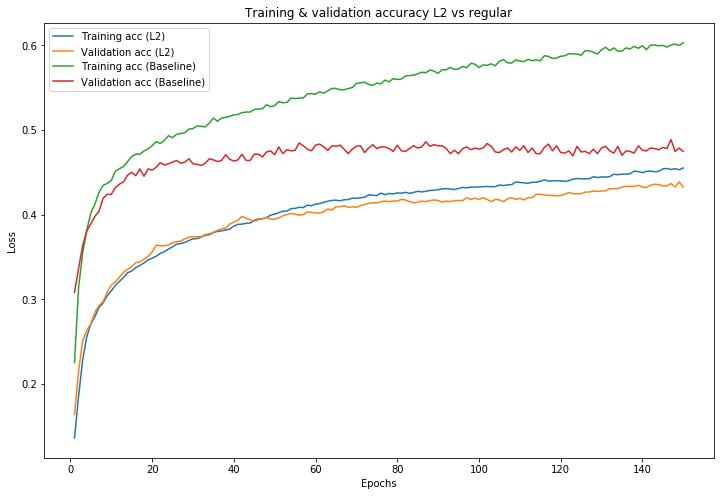

In [39]:
# L2 model details
L2_model_dict = L2_model_val.history
L2_acc_values = L2_model_dict['acc'] 
L2_val_acc_values = L2_model_dict['val_acc']

# Baseline model
baseline_model_acc = baseline_model_val_dict['acc'] 
baseline_model_val_acc = baseline_model_val_dict['val_acc']

# Plot the accuracy for these models
fig, ax = plt.subplots(figsize=(12, 8))
epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, L2_acc_values, label='Training acc (L2)')
ax.plot(epochs, L2_val_acc_values, label='Validation acc (L2)')
ax.plot(epochs, baseline_model_acc, label='Training acc (Baseline)')
ax.plot(epochs, baseline_model_val_acc, label='Validation acc (Baseline)')
ax.set_title('Training & validation accuracy L2 vs regular')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [40]:
random.seed(123)
L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(29,)))

# Add a hidden layer
L1_model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Train the model 
L1_model_val = L1_model.fit(X_train, 
                            y_train_lb, 
                            epochs=150, 
                            batch_size=256, 
                            validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 0s 31us/step - loss: 4.0925 - acc: 0.1053 - val_loss: 4.0248 - val_acc: 0.1213
Epoch 2/150
6497/6497 [==============================] - 0s 6us/step - loss: 3.9825 - acc: 0.1416 - val_loss: 3.9395 - val_acc: 0.1387
Epoch 3/150
6497/6497 [==============================] - 0s 6us/step - loss: 3.9097 - acc: 0.1652 - val_loss: 3.8762 - val_acc: 0.1607
Epoch 4/150
6497/6497 [==============================] - 0s 6us/step - loss: 3.8530 - acc: 0.1879 - val_loss: 3.8245 - val_acc: 0.1893
Epoch 5/150
6497/6497 [==============================] - 0s 7us/step - loss: 3.8051 - acc: 0.2101 - val_loss: 3.7797 - val_acc: 0.2113
Epoch 6/150
6497/6497 [==============================] - 0s 7us/step - loss: 3.7631 - acc: 0.2261 - val_loss: 3.7401 - val_acc: 0.2253
Epoch 7/150
6497/6497 [==============================] - 0s 7us/step - loss: 3.7251 - acc: 0.2421 - val_loss: 3.7040 - val_acc: 0.2393
Epoch 

Epoch 61/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.6968 - acc: 0.3974 - val_loss: 2.6973 - val_acc: 0.3880
Epoch 62/150
6497/6497 [==============================] - 0s 8us/step - loss: 2.6839 - acc: 0.3977 - val_loss: 2.6846 - val_acc: 0.3900
Epoch 63/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.6712 - acc: 0.3988 - val_loss: 2.6718 - val_acc: 0.3900
Epoch 64/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.6586 - acc: 0.4006 - val_loss: 2.6595 - val_acc: 0.3887
Epoch 65/150
6497/6497 [==============================] - 0s 6us/step - loss: 2.6461 - acc: 0.4006 - val_loss: 2.6469 - val_acc: 0.3920
Epoch 66/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.6337 - acc: 0.4017 - val_loss: 2.6346 - val_acc: 0.3927
Epoch 67/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.6215 - acc: 0.4022 - val_loss: 2.6222 - val_acc: 0.3920
Epoch 68/150
6497/6497 [========================

6497/6497 [==============================] - 0s 6us/step - loss: 2.1423 - acc: 0.4150 - val_loss: 2.1419 - val_acc: 0.4067
Epoch 122/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1361 - acc: 0.4148 - val_loss: 2.1357 - val_acc: 0.4087
Epoch 123/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1301 - acc: 0.4136 - val_loss: 2.1294 - val_acc: 0.4067
Epoch 124/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1241 - acc: 0.4134 - val_loss: 2.1233 - val_acc: 0.4100
Epoch 125/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1181 - acc: 0.4125 - val_loss: 2.1173 - val_acc: 0.4100
Epoch 126/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1123 - acc: 0.4142 - val_loss: 2.1112 - val_acc: 0.4140
Epoch 127/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1065 - acc: 0.4113 - val_loss: 2.1052 - val_acc: 0.4113
Epoch 128/150
6497/6497 [==============================

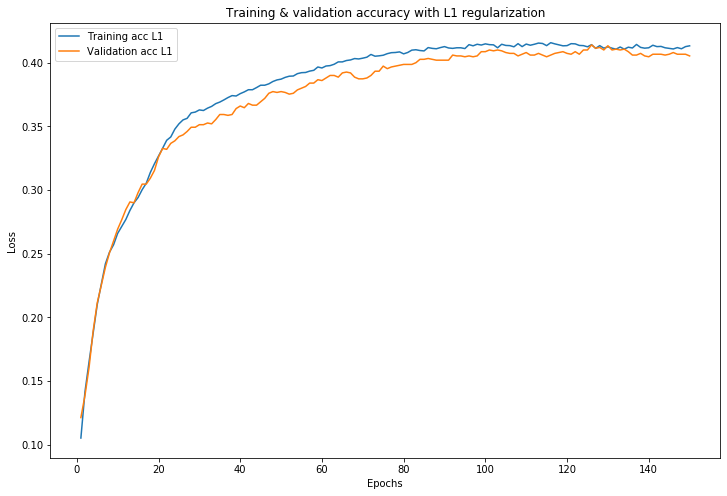

In [41]:
fig, ax = plt.subplots(figsize=(12, 8))

L1_model_dict = L1_model_val.history

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
ax.plot(epochs, acc_values, label='Training acc L1')
ax.plot(epochs, val_acc_values, label='Validation acc L1')
ax.set_title('Training & validation accuracy with L1 regularization')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend();

In [42]:
# ⏰ This cell may take about a minute to run
random.seed(123)
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(29,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(50, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(25, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(8, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='SGD', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Train the model
dropout_model_val = dropout_model.fit(X_train, 
                                      y_train_lb, 
                                      epochs=150, 
                                      batch_size=256, 
                                      validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 0s 42us/step - loss: 2.3817 - acc: 0.1133 - val_loss: 2.1490 - val_acc: 0.1120
Epoch 2/150
6497/6497 [==============================] - 0s 8us/step - loss: 2.2721 - acc: 0.1305 - val_loss: 2.0974 - val_acc: 0.1420
Epoch 3/150
6497/6497 [==============================] - 0s 8us/step - loss: 2.2254 - acc: 0.1379 - val_loss: 2.0643 - val_acc: 0.1547
Epoch 4/150
6497/6497 [==============================] - 0s 8us/step - loss: 2.1707 - acc: 0.1414 - val_loss: 2.0410 - val_acc: 0.1713
Epoch 5/150
6497/6497 [==============================] - 0s 8us/step - loss: 2.1528 - acc: 0.1473 - val_loss: 2.0243 - val_acc: 0.1847
Epoch 6/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1290 - acc: 0.1599 - val_loss: 2.0112 - val_acc: 0.2067
Epoch 7/150
6497/6497 [==============================] - 0s 7us/step - loss: 2.1017 - acc: 0.1665 - val_loss: 2.0002 - val_acc: 0.2207
Epoch 

Epoch 61/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8633 - acc: 0.2769 - val_loss: 1.7810 - val_acc: 0.3527
Epoch 62/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8801 - acc: 0.2795 - val_loss: 1.7804 - val_acc: 0.3540
Epoch 63/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8646 - acc: 0.2778 - val_loss: 1.7785 - val_acc: 0.3580
Epoch 64/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8716 - acc: 0.2843 - val_loss: 1.7771 - val_acc: 0.3560
Epoch 65/150
6497/6497 [==============================] - 0s 9us/step - loss: 1.8613 - acc: 0.2900 - val_loss: 1.7752 - val_acc: 0.3520
Epoch 66/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8669 - acc: 0.2798 - val_loss: 1.7735 - val_acc: 0.3547
Epoch 67/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8597 - acc: 0.2883 - val_loss: 1.7721 - val_acc: 0.3540
Epoch 68/150
6497/6497 [========================

6497/6497 [==============================] - 0s 8us/step - loss: 1.8137 - acc: 0.3174 - val_loss: 1.7152 - val_acc: 0.3760
Epoch 122/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8049 - acc: 0.3192 - val_loss: 1.7142 - val_acc: 0.3760
Epoch 123/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8155 - acc: 0.3123 - val_loss: 1.7136 - val_acc: 0.3760
Epoch 124/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8057 - acc: 0.3128 - val_loss: 1.7128 - val_acc: 0.3747
Epoch 125/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8041 - acc: 0.3180 - val_loss: 1.7122 - val_acc: 0.3740
Epoch 126/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8077 - acc: 0.3197 - val_loss: 1.7112 - val_acc: 0.3740
Epoch 127/150
6497/6497 [==============================] - 0s 8us/step - loss: 1.8023 - acc: 0.3277 - val_loss: 1.7109 - val_acc: 0.3740
Epoch 128/150
6497/6497 [==============================

In [43]:
results_train = dropout_model.evaluate(X_train, y_train_lb)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = dropout_model.evaluate(X_test, y_test_lb)
print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')   

6497/6497 [==============================] - 0s 18us/step
Training Loss: 1.69 
Training Accuracy: 0.385
----------
1600/1600 [==============================] - 0s 16us/step
Test Loss: 1.69 
Test Accuracy: 0.37


# Normalization

In [44]:
X_val.shape

(1500, 29)

In [45]:
y_val.shape

(1500, 1)

In [46]:
y_val

,genre
track_id,
78843,Hip-Hop
143303,Instrumental
16819,Rock
91622,Electronic
31999,Rock
...,...
56639,Hip-Hop
73568,Folk
124470,Rock


In [47]:
y_train

,genre
track_id,
5,Hip-Hop
129040,Instrumental
108475,Instrumental
150288,Hip-Hop
97844,Electronic
...,...
10992,Folk
58169,Pop
96695,Folk


In [48]:
np.random.seed(123)
baseline_model = Sequential()

# Hidden layer with 100 units
baseline_model.add(layers.Dense(100, activation='relu', input_shape=(29,)))

# Hidden layer with 50 units
baseline_model.add(layers.Dense(50, activation='relu'))

# Output layer
baseline_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
baseline_model.compile(optimizer='SGD', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Train the model
baseline_model.fit(X_train, 
                   y_train_lb, 
                   batch_size=32, 
                   epochs=150, 
                   validation_data=(X_val, y_val_lb))

NameError: name 'Sequential' is not defined

In [159]:
np.random.seed(123)
he_model = Sequential()

# Add the first hidden layer
he_model.add(layers.Dense(100, kernel_initializer='he_normal', activation='relu', input_shape=(29,)))

# Add another hidden layer
he_model.add(layers.Dense(50, activation='relu'))

# Add an output layer
he_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
he_model.compile(optimizer='SGD', 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

# Train the model
he_model.fit(X_train, 
             y_train_lb, 
             batch_size=32, 
             epochs=150, 
             validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 1s 123us/step - loss: 1.9134 - acc: 0.2772 - val_loss: 1.8054 - val_acc: 0.3307
Epoch 2/150
6497/6497 [==============================] - 0s 42us/step - loss: 1.7325 - acc: 0.3585 - val_loss: 1.7396 - val_acc: 0.3573
Epoch 3/150
6497/6497 [==============================] - 0s 41us/step - loss: 1.6709 - acc: 0.3897 - val_loss: 1.7222 - val_acc: 0.3573
Epoch 4/150
6497/6497 [==============================] - 0s 42us/step - loss: 1.6322 - acc: 0.4054 - val_loss: 1.6745 - val_acc: 0.3820
Epoch 5/150
6497/6497 [==============================] - 0s 41us/step - loss: 1.6026 - acc: 0.4191 - val_loss: 1.6671 - val_acc: 0.3860
Epoch 6/150
6497/6497 [==============================] - 0s 42us/step - loss: 1.5812 - acc: 0.4284 - val_loss: 1.6423 - val_acc: 0.4080
Epoch 7/150
6497/6497 [==============================] - 0s 52us/step - loss: 1.5606 - acc: 0.4390 - val_loss: 1.6454 - val_acc: 0.4040

Epoch 120/150
6497/6497 [==============================] - 0s 38us/step - loss: 1.0040 - acc: 0.6472 - val_loss: 1.8917 - val_acc: 0.3967
Epoch 121/150
6497/6497 [==============================] - 0s 37us/step - loss: 1.0069 - acc: 0.6486 - val_loss: 1.7133 - val_acc: 0.4467
Epoch 122/150
6497/6497 [==============================] - 0s 42us/step - loss: 0.9987 - acc: 0.6512 - val_loss: 1.7020 - val_acc: 0.4647
Epoch 123/150
6497/6497 [==============================] - 0s 39us/step - loss: 0.9949 - acc: 0.6520 - val_loss: 1.6892 - val_acc: 0.4627
Epoch 124/150
6497/6497 [==============================] - 0s 37us/step - loss: 0.9917 - acc: 0.6545 - val_loss: 1.7041 - val_acc: 0.4587
Epoch 125/150
6497/6497 [==============================] - 0s 37us/step - loss: 0.9869 - acc: 0.6577 - val_loss: 1.6922 - val_acc: 0.4627
Epoch 126/150
6497/6497 [==============================] - 0s 40us/step - loss: 0.9856 - acc: 0.6543 - val_loss: 1.7411 - val_acc: 0.4520
Epoch 127/150
6497/6497 [=========

In [160]:
he_model.evaluate(X_train, y_train_lb)


6497/6497 [==============================] - 0s 23us/step


[1.2158758414558617, 0.5768816376789287]

In [161]:
he_model.evaluate(X_val, y_val_lb)


1500/1500 [==============================] - 0s 23us/step


[2.0669147981007896, 0.4119999997615814]

In [178]:
np.random.seed(123)
rmsprop_model = Sequential()
rmsprop_model.add(layers.Dense(100, activation='relu', input_shape=(29,)))
rmsprop_model.add(layers.Dense(50, activation='relu'))
rmsprop_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
rmsprop_model.compile(optimizer='rmsprop', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

# Train the model
rmsprop_model.fit(X_train, 
                  y_train_lb, 
                  batch_size=32, 
                  epochs=150, 
                  validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 1s 136us/step - loss: 1.7250 - acc: 0.3620 - val_loss: 1.6431 - val_acc: 0.3947
Epoch 2/150
6497/6497 [==============================] - 0s 46us/step - loss: 1.5644 - acc: 0.4314 - val_loss: 1.6060 - val_acc: 0.4233
Epoch 3/150
6497/6497 [==============================] - 0s 42us/step - loss: 1.5042 - acc: 0.4590 - val_loss: 1.6010 - val_acc: 0.4173
Epoch 4/150
6497/6497 [==============================] - 0s 46us/step - loss: 1.4625 - acc: 0.4731 - val_loss: 1.5674 - val_acc: 0.4267
Epoch 5/150
6497/6497 [==============================] - 0s 45us/step - loss: 1.4308 - acc: 0.4825 - val_loss: 1.5543 - val_acc: 0.4327
Epoch 6/150
6497/6497 [==============================] - 0s 46us/step - loss: 1.4027 - acc: 0.4928 - val_loss: 1.5421 - val_acc: 0.4400
Epoch 7/150
6497/6497 [==============================] - 0s 43us/step - loss: 1.3779 - acc: 0.5033 - val_loss: 1.5373 - val_acc: 0.4513

Epoch 120/150
6497/6497 [==============================] - 0s 51us/step - loss: 0.5403 - acc: 0.8179 - val_loss: 2.6982 - val_acc: 0.4233
Epoch 121/150
6497/6497 [==============================] - 0s 51us/step - loss: 0.5311 - acc: 0.8207 - val_loss: 2.7399 - val_acc: 0.4200
Epoch 122/150
6497/6497 [==============================] - 0s 55us/step - loss: 0.5332 - acc: 0.8185 - val_loss: 2.6903 - val_acc: 0.4340
Epoch 123/150
6497/6497 [==============================] - 0s 51us/step - loss: 0.5305 - acc: 0.8185 - val_loss: 2.7472 - val_acc: 0.4420
Epoch 124/150
6497/6497 [==============================] - 0s 50us/step - loss: 0.5266 - acc: 0.8191 - val_loss: 2.7565 - val_acc: 0.4413
Epoch 125/150
6497/6497 [==============================] - 0s 48us/step - loss: 0.5201 - acc: 0.8221 - val_loss: 2.7362 - val_acc: 0.4440
Epoch 126/150
6497/6497 [==============================] - 0s 50us/step - loss: 0.5227 - acc: 0.8231 - val_loss: 2.7902 - val_acc: 0.4400
Epoch 127/150
6497/6497 [=========

In [179]:
rmsprop_model.evaluate(X_train, y_train_lb)


6497/6497 [==============================] - 0s 25us/step


[0.4706420089091377, 0.8343851008157611]

In [180]:
rmsprop_model.evaluate(X_test, y_test_lb)


1600/1600 [==============================] - 0s 28us/step


[0.9186966180801391, 0.769375]

In [181]:
rmsprop_model.evaluate(X_val, y_val_lb)


1500/1500 [==============================] - 0s 24us/step


[3.214422403971354, 0.42466666650772095]

In [ ]:
np.random.seed(123)
rmsprop_model = Sequential()
rmsprop_model.add(layers.Dense(100, activation='relu', input_shape=(29,)))
rmsprop_model.add(layers.Dense(50, activation='relu'))
rmsprop_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
rmsprop_model.compile(optimizer='rmsprop', 
                      loss='mse', 
                      metrics=['accuracy'])

# Train the model
rmsprop_model.fit(X_train, 
                  y_train_lb, 
                  batch_size=32, 
                  epochs=150, 
                  validation_data=(X_val, y_val_lb))

In [169]:
adam_model = Sequential()
adam_model.add(layers.Dense(100, activation='relu', input_shape=(29,)))
adam_model.add(layers.Dense(50, activation='relu'))
adam_model.add(layers.Dense(8, activation='softmax'))

# Compile the model
adam_model.compile(optimizer='Adam', 
                   loss='spar', 
                   metrics=['accuracy'])

# Train the model
adam_model.fit(X_train, 
               y_train_lb, 
               batch_size=32, 
               epochs=150, 
               validation_data=(X_val, y_val_lb))

Train on 6497 samples, validate on 1500 samples
Epoch 1/150
6497/6497 [==============================] - 1s 149us/step - loss: 0.0967 - acc: 0.3542 - val_loss: 0.0920 - val_acc: 0.4107
Epoch 2/150
6497/6497 [==============================] - 0s 47us/step - loss: 0.0881 - acc: 0.4376 - val_loss: 0.0884 - val_acc: 0.4367
Epoch 3/150
6497/6497 [==============================] - 0s 47us/step - loss: 0.0850 - acc: 0.4601 - val_loss: 0.0882 - val_acc: 0.4327
Epoch 4/150
6497/6497 [==============================] - 0s 46us/step - loss: 0.0833 - acc: 0.4765 - val_loss: 0.0867 - val_acc: 0.4573
Epoch 5/150
6497/6497 [==============================] - 0s 51us/step - loss: 0.0818 - acc: 0.4939 - val_loss: 0.0866 - val_acc: 0.4553
Epoch 6/150
6497/6497 [==============================] - 0s 49us/step - loss: 0.0801 - acc: 0.5067 - val_loss: 0.0856 - val_acc: 0.4613
Epoch 7/150
6497/6497 [==============================] - 0s 52us/step - loss: 0.0786 - acc: 0.5167 - val_loss: 0.0856 - val_acc: 0.4633

Epoch 120/150
6497/6497 [==============================] - 0s 46us/step - loss: 0.0292 - acc: 0.8607 - val_loss: 0.1099 - val_acc: 0.4467
Epoch 121/150
6497/6497 [==============================] - 0s 48us/step - loss: 0.0302 - acc: 0.8576 - val_loss: 0.1099 - val_acc: 0.4393
Epoch 122/150
6497/6497 [==============================] - 0s 42us/step - loss: 0.0294 - acc: 0.8589 - val_loss: 0.1087 - val_acc: 0.4567
Epoch 123/150
6497/6497 [==============================] - 0s 61us/step - loss: 0.0292 - acc: 0.8616 - val_loss: 0.1087 - val_acc: 0.4487
Epoch 124/150
6497/6497 [==============================] - 0s 49us/step - loss: 0.0296 - acc: 0.8593 - val_loss: 0.1097 - val_acc: 0.4573
Epoch 125/150
6497/6497 [==============================] - 0s 49us/step - loss: 0.0297 - acc: 0.8569 - val_loss: 0.1107 - val_acc: 0.4420
Epoch 126/150
6497/6497 [==============================] - 0s 50us/step - loss: 0.0288 - acc: 0.8652 - val_loss: 0.1087 - val_acc: 0.4593
Epoch 127/150
6497/6497 [=========

In [182]:
rmsprop_model.evaluate(X_test, y_test_lb)


1600/1600 [==============================] - 0s 24us/step


[0.9186966180801391, 0.769375]

In [183]:
# Generate predictions on test data
y_test_pred = rmsprop_model.predict(X_test)


In [194]:
np.argmax(y_test_pred[0]),np.argmax(y_test_pred[1]),np.argmax(y_test_pred[2])

(2, 1, 5)

In [189]:
d = pd.DataFrame(y_test_pred)

In [191]:
d['pred'] = np.argmax(d.iloc[])

In [192]:
d['pred']

0       417
1       417
2       417
3       417
4       417
       ... 
1595    417
1596    417
1597    417
1598    417
1599    417
Name: pred, Length: 1600, dtype: int64

In [177]:
y_test_lb

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [174]:
y_train_lb

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)